#Lasse Filz

<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/time_series_forecasting/4_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Continuity


> Samples are needed for sequence models and transformer models for input


😈 **Task 1:** How does a basic MLP differ from models like RNNs or ARIMA when used for time series forecasting?

😈 **Question 1:** What challenges might arise when feeding sequences into a feedforward model like an MLP?



In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import os

context_window = 336
prediction_horizon = 96
# variable_column = ["no2", "temp", "o3", "no", "press"]
variable_column = ["temp","o3"]

In [8]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    return rmse

## Download the .pkl files from drive

In [10]:
import pandas as pd

df = pd.read_csv("normalized_data_multi.csv")
print(df.head(5), df.shape)

   longitude   latitude station_code                   datetime      temp  \
0   6.093923  50.754704      DENW094  1997-01-01 00:00:00+00:00 -3.619563   
1   6.093923  50.754704      DENW094  1997-01-01 01:00:00+00:00 -3.687869   
2   6.093923  50.754704      DENW094  1997-01-01 02:00:00+00:00 -3.701530   
3   6.093923  50.754704      DENW094  1997-01-01 03:00:00+00:00 -3.797159   
4   6.093923  50.754704      DENW094  1997-01-01 04:00:00+00:00 -3.824481   

         o3  
0 -1.677284  
1 -1.677284  
2 -1.677284  
3 -1.677284  
4 -1.677284   (221564, 6)


In [11]:
# Function to create continous time-series data with past 24 hours as input and next 6 hours as output
def create_sequences(data, variable_column, n_past=48, n_future=24):
    df = data.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values(['station_code', 'datetime']).reset_index(drop=True)

    # 1) Encode station_code as a small integer (categorical codes) to save memory
    df['sc_code'] = df['station_code'].astype('category')

    # 2) Boolean mask: True if exactly 1 hour after the previous row (per station)
    is1h = (
        df.groupby('station_code')['datetime']
          .diff()
          .eq(pd.Timedelta(hours=1))
    )

    # 3) Compute how many consecutive “True” over (n_past + n_future - 1) rows
    gap_window = n_past + n_future - 1
    run = (
        is1h.groupby(df['station_code'])
            .rolling(window=gap_window, min_periods=gap_window)
            .sum()
            .reset_index(level=0, drop=True)
    )

    # 4) 'ends' are indices where run == gap_window (end of a full-length continuous block)
    ends = run[run == gap_window].index

    # 5) Grab column‐arrays for encoded station code and the variable
    sc_arr  = df['sc_code'].values
    vals    = df[variable_column].values

    X_list = []
    y_list = []
    for end_idx in ends:
        start_idx = end_idx - gap_window
        if start_idx >= 0 and sc_arr[start_idx] == sc_arr[end_idx]:
            station_block = sc_arr[start_idx : end_idx + 1]
            var_block     = vals[start_idx : end_idx + 1]

            block = np.column_stack((station_block, var_block))

            X_list.append(block[:n_past, :])
            y_list.append(block[n_past:, :])

    if not X_list:
        # No valid windows
        return np.empty((0, n_past, 2)), np.empty((0, n_future, 2))

    X = np.stack(X_list)  # shape = (num_windows, n_past, 2)
    y = np.stack(y_list)  # shape = (num_windows, n_future, 2)
    return X, y

# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    return rmse

In [12]:
context_window = 336
prediction_horizon = 96

X, y = create_sequences(df,variable_column,context_window,prediction_horizon)

train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

431.0
X_train shape: (121085, 336, 3), y_train shape: (121085, 96, 3)
X_test shape: (51894, 336, 3), y_test shape: (51894, 96, 3)


### Forecasting with Simple Neural Network: MLP

> The below snippet uses tensorflow to create a simple

😈 **Task 2:** Try changing the number of input lags used. How does it affect forecasting accuracy?

😈 **Task 3:** Compare results using `no2` vs `o3` as the target variable.


The below cell has sample hyperparameters and activation, loss functions, Modify these values for experimentation


😈 **Task 4:** Modify the activation function to `tanh` or `selu`. How does training performance change?

😈 **Task 5:** Try different optimizers (e.g., SGD, RMSProp) and compare their impact on convergence.

😈 **Question 2:** Why might ReLU not be ideal for all types of time series data?

In [22]:
## Remember the checkpoints made available are trained with below hyper params
# If changed you will have to retrain loading appropriate inputs like eg. loss
mlp_hidden_units = [64, 32]
mlp_epochs = 30
mlp_batch_size = 32
activation_fn='relu'
mlp_optim = 'adam'
mlp_loss = 'mse'

### Load the checkpoint

In [25]:


num_variables = 2 #len(variable_column)
mlp_predictions = []
training_histories = {}

X_train_single = X_train[:, :, 1:3].astype(np.float32)  # Shape: (samples, context_window)
y_train_single = y_train[:, :, 2].astype(np.float32)# Shape: (samples, pred_horizon)
X_test_single = X_test[:, :, 1:3].astype(np.float32)  # Shape: (samples, context_window)

X_train_single = X_train_single.reshape(X_train_single.shape[0], -1)
X_test_single = X_test_single.reshape(X_test_single.shape[0], -1)


y_train_single = y_train_single.reshape(y_train_single.shape[0], -1)

# Build MLP model
mlp_model = Sequential([
    Input(shape=(X_train_single.shape[1],)),  # 24 timesteps (context window)
    Dense(mlp_hidden_units[0], activation=activation_fn)
])

for units in mlp_hidden_units[1:]:
    mlp_model.add(Dense(units, activation=activation_fn))

mlp_model.add(Dense(y_train_single.shape[1]))  # 6 timesteps (pred horizon)
mlp_model.compile(optimizer=mlp_optim, loss=mlp_loss)

#checkpoint_callback = ModelCheckpoint(
#    checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1
#)

# Train model
training = mlp_model.fit(
    X_train_single, y_train_single,
    epochs=mlp_epochs, batch_size=mlp_batch_size,
    validation_split=0.2, verbose=1
)


y_pred_single = mlp_model.predict(X_test_single.astype(np.float32))  # shape: (samples, pred_horizon)
mlp_predictions.append(y_pred_single)
# mlp_predictions is a list with 1 element (the prediction array)
mlp_predictions = mlp_predictions[0]  # just take the first (and only) prediction array

Epoch 1/30
3028/3028 ━━━━━━━━━━━━━━━━━━━━ 2s 626us/step - loss: 0.6746 - val_loss: 0.5680
Epoch 2/30
3028/3028 ━━━━━━━━━━━━━━━━━━━━ 2s 623us/step - loss: 0.5703 - val_loss: 0.5647
Epoch 3/30
3028/3028 ━━━━━━━━━━━━━━━━━━━━ 2s 615us/step - loss: 0.5519 - val_loss: 0.5632
Epoch 4/30
3028/3028 ━━━━━━━━━━━━━━━━━━━━ 2s 602us/step - loss: 0.5367 - val_loss: 0.5766
Epoch 5/30
3028/3028 ━━━━━━━━━━━━━━━━━━━━ 2s 624us/step - loss: 0.5300 - val_loss: 0.5859
Epoch 6/30
3028/3028 ━━━━━━━━━━━━━━━━━━━━ 2s 627us/step - loss: 0.5210 - val_loss: 0.5869
Epoch 7/30
3028/3028 ━━━━━━━━━━━━━━━━━━━━ 2s 622us/step - loss: 0.5155 - val_loss: 0.5939
Epoch 8/30
3028/3028 ━━━━━━━━━━━━━━━━━━━━ 2s 620us/step - loss: 0.5111 - val_loss: 0.6035
Epoch 9/30
3028/3028 ━━━━━━━━━━━━━━━━━━━━ 2s 607us/step - loss: 0.5058 - val_loss: 0.6161
Epoch 10/30
3028/3028 ━━━━━━━━━━━━━━━━━━━━ 2s 584us/step - loss: 0.5019 - val_loss: 0.6019
Epoch 11/30
3028/3028 ━━━━━━━━━━━━━━━━━━━━ 2s 587us/step - loss: 0.4984 - val_loss: 0.5985
Epoch 12

In [26]:
y_test_reshaped = y_test.reshape(y_test.shape[0], prediction_horizon, 3)
y_test_var = y_test_reshaped[:, :, 2]  # ozone variable target
evaluate_model(y_test_var, y_pred_single)



RMSE: 0.7832


0.7831879421674597

{'temp': {'mean': 10.645179247129887, 'std': 7.319994467459135}, 'o3': {'mean': 24.565799430301844, 'std': 14.64617346696584}}


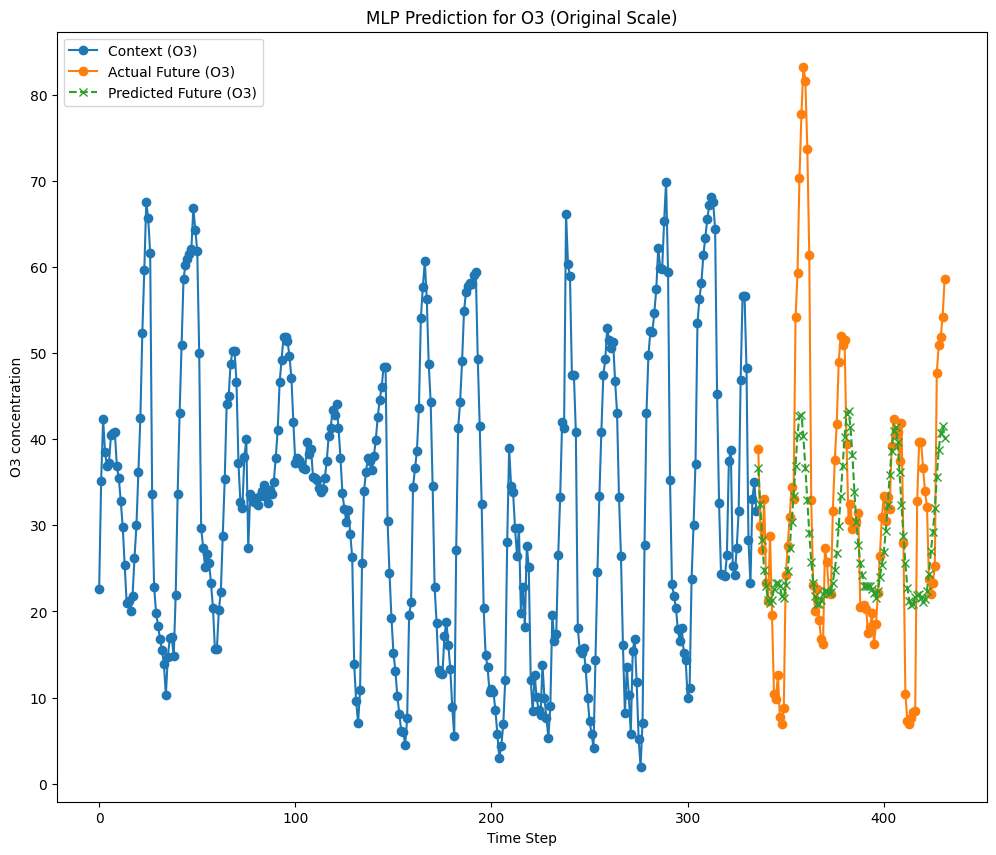

In [27]:
import matplotlib.pyplot as plt

# Pick a sample index to visualize
sample_idx = 1  # change to any sample you want to check

# Your context input for that sample (flattened, so reshape back to (context_window, num_vars))
context_window = X_test_single.shape[1] // 2  # since you took 2 variables and flattened
num_vars = 2

df_scale = pd.read_csv("not_normalized_data_multi.csv")
scaler_stats = {col: {'mean': df_scale[col].mean(), 'std': df_scale[col].std()} for col in variable_column}
print(scaler_stats)
context = X_test_single[sample_idx].reshape(context_window, num_vars)  # shape (context_window, 2)

# O3 context
context_o3 = context[:, 1]

# Actual future values for O3 (prediction target)
actual_future = y_test[sample_idx, :, 2]  # shape (prediction_horizon,)

# Predicted future values for O3
predicted_future = mlp_predictions[sample_idx, :]  # shape (prediction_horizon,)

# --- Inverse-transform all of them ---
o3_mean = scaler_stats['o3']['mean']
o3_std = scaler_stats['o3']['std']

context_o3_real = context_o3 * o3_std + o3_mean
actual_future_real = actual_future * o3_std + o3_mean
predicted_future_real = predicted_future * o3_std + o3_mean

# Plot
plt.figure(figsize=(12, 10))
plt.plot(range(context_window), context_o3_real, label='Context (O3)', marker='o')
plt.plot(range(context_window, context_window + len(actual_future_real)),
         actual_future_real, label='Actual Future (O3)', marker='o')
plt.plot(range(context_window, context_window + len(predicted_future_real)),
         predicted_future_real, label='Predicted Future (O3)', marker='x', linestyle='--')

plt.title("MLP Prediction for O3 (Original Scale)")
plt.xlabel("Time Step")
plt.ylabel("O3 concentration")
plt.legend()
plt.show()

# Save context, actual, and predicted for each variable into a named file
np.savez(
    "mlp_results_temp_and_ozone.npz",
    context=context_o3_real,
    actual_future=actual_future_real,
    predicted_future=predicted_future_real,
    variable_column=variable_column
)